# Word Sense Disambiguation using Neural Networks
Adam Ek

----------------------------------

The lab is an exploration and learning exercise to be done in a group and also in discussion with the teachers and other students.

Before starting, please read the instructions on [how to work on group assignments](https://github.com/sdobnik/computational-semantics/blob/master/README.md).

Write all your answers and the code in the appropriate boxes below.

----------------------------------

A problem with static distributional vectors is the difficulty of distinguishing between different *word senses*. We will continue our exploration of word vectors by considering *trainable vectors* or *word embeddings* for Word Sense Disambiguation (WSD).

The goal of word sense disambiguation is to train a model to find the sense of a word (homonyms of a word-form). For example, the word "bank" can mean "sloping land" or "financial institution". 

(a) "I deposited my money in the **bank**" (financial institution)

(b) "I swam from the river **bank**" (sloping land)

In case a) and b) we can determine that the meaning of "bank" based on the *context*. To utilize context in a semantic model we use *contextualized word representations*. Previously we worked with *static word representations*, i.e. the representation does not depend on the context. To illustrate we can consider sentences (a) and (b), the word **bank** would have the same static representation in both sentences, which means that it becomes difficult for us to predict its sense. What we want is to create representations that depend on the context, i.e. *contextualized embeddings*. 

We will create contextualized embeddings with Recurrent Neural Networks. You can read more about recurrent neural netoworks [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). Your overall task in this lab is to create a neural network model that can disambiguate the word sense of 30 different words. 

In [1]:
# first we import some packages that we need
import torch
import torch.nn as nn

# our hyperparameters (add more when/if you need them)
device = torch.device('cuda:3')

batch_size = 8
learning_rate = 0.001
epochs = 3

In [7]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 17.0 MB 3.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.6 MB 3.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 3.7 MB/s            
     |████████████████████████████████| 42.2 MB 28.0 MB/s            
     |████████████████████████████████| 11.9 MB 87.2 MB/s            
     |████████████████████████████████| 1.6 MB 95.3 MB/s            
     |████████████████████████████████| 3.1 MB 88.7 MB/s            
     |████████████████████████████████| 930 kB 93.8 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
#other packages that we are going to use
import csv
import random
import math

import numpy as np
import pandas as pd

# 1. Working with data

A central part of any machine learning system is the data we're working with. In this section we will split the data (the dataset is located here: ``wsd-data/wsd_data.txt``) into a training set and a test set. We will also create a baseline to compare our model against. Finally, we will use TorchText to transform our data (raw text) into a convenient format that our neural network can work with.

## Data

The dataset we will use contain different word sense for 30 different words. The data is organized as follows (values separated by tabs): 
- Column 1: word-sense
- Column 2: word-form
- Column 3: index of word
- Column 4: white-space tokenized context

### Splitting the data

Your first task is to seperate the data into a *training set* and a *test set*. The training set should contain 80% of the examples and the test set the remaining 20%. The examples for the test/training set should be selected **randomly**. Save each dataset into a .csv file for loading later. **[2 marks]**

### DO NOT RE-RUN THESE CELLS!  
They are here ONLY to make the data split once and save it. Re-running them will mess up the data split and will render them useless for testing anything on the saved BERT model. Continue from "creating a baseline".

In [3]:
def data_split(path_to_dataset):
    # your code goes here
    with open(path_to_dataset) as file:
        lines = file.readlines()
    
    clean_lines = []
    for line in lines:
        clean_line = line.strip().split("\t")
        clean_lines.append(clean_line)
        
    shuffled_lines = random.sample(clean_lines, len(clean_lines))
    
    # it will not be an exact 80/20 unless the set allows for it, this way the training set is marginally larger than 80%
    training_cutoff = math.ceil(len(clean_lines)*0.8)  
    
    training = shuffled_lines[:training_cutoff]
    testing = shuffled_lines[training_cutoff:]
        
    return training, testing

In [4]:
train, test = data_split('wsd_data.txt')

In [5]:
print(len(train))
print(len(test))

print(len(test)/(len(test)+len(train)))

60840
15209
0.1999894804665413


In [6]:
def data_save(train, test, train_file, test_file):
    
    with open(train_file, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerows(train)
        
    with open(test_file, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerows(test)

In [7]:
data_save(train, test, 'wsd_train.csv', 'wsd_test.csv')

In [8]:
with open('wsd_test.csv') as f:
    reader = csv.reader(f)
    rows = []
    for row in reader:
        rows.append(row)
        
for row in rows:
    if len(row) != 4:
        print("oopsie, your file does not work")

### Creating a baseline

Your second task is to create a *baseline* for the task. A baseline is a "reality check" for a model, given a very simple heuristic/algorithmic/model solution to the problem, can our neural network perform better than this?
The baseline you are to create is the "most common sense" (MCS) baseline. For each word form, find the most commonly assigned sense to the word, and label a words with that sense. **[2 marks]**

E.g. In a fictional dataset, "bank" have two senses, "financial institution" which occur 5 times and "side of river" 3 times. Thus, all 8 occurences of bank is labeled "financial institution" and this yields an MCS accuracy of 5/8 = 62.5%. If a model obtain a higher score than this, we can conclude that the model *at least* is better than selecting the most frequent word sense.

In [3]:
train_data = pd.read_csv('wsd_train.csv', header=None)
train_data.columns = ['word-sense', 'word-form', 'index', 'context']
test_data = pd.read_csv('wsd_test.csv', header=None)
test_data.columns = ['word-sense', 'word-form', 'index', 'context']

In [4]:
def mcs_baseline_2(train_data, test_data):
    msc_mapping = {}
    for word_form, df in train_data.groupby('word-form'):
        msc_mapping[word_form] = df['word-sense'].value_counts().idxmax()

    #'missing' incase (unlikely) all observations of one word-form ends up in test_data.
    msc_test_results = test_data['word-form'].apply(lambda x: msc_mapping.get(x, 'missing'))

    #return msc_test_results
    accuracy = np.sum(msc_test_results == test_data['word-sense'])/len(test_data)
    return accuracy      

In [5]:
print(f'MSC Baseline Accuracy: {round(mcs_baseline_2(train_data, test_data)*100,2)}%')

MSC Baseline Accuracy: 31.09%


These two yield similar results, but there is a bit of a difference between them, which is why we wanted to show both.

### What happens if we remove the word from the word sense? 
Example: keep%2:42:07:: -> 2:42:07::

In [6]:
data = pd.read_csv('wsd_data.txt', sep='\t', header=None)
data.columns = ['word-sense', 'word-form', 'index', 'context']

In [7]:
# this function will be needed for getting per-word-form accuracy
def get_wf(w):
    # keep%2:42:07:: -> keep
    splt = w.split('%')
    if len(splt)!=2:
        raise Exception('Unknown word-sense format')
    return splt[0]

In [8]:
def remove_word(w):
    # keep%2:42:07:: -> 2:42:07::
    splt = w.split('%')
    if len(splt)!=2:
        raise Exception('Unknown word-sense format')
    return splt[-1]

print(len(np.unique(data['word-sense'])))
print(len(np.unique(data['word-sense'].apply(remove_word))))

222
135


In [9]:
data['word-sense-generalized'] = data['word-sense'].apply(remove_word)

Observation/Idea: From 222 unique instances to 135, i.e there is some overlap between the word-sense codes. The result implies that we can possibly improve generalization by removing the word from word-sense. As the word itself is not unknown and can be readded after prediction.

### Creating data iterators

To train a neural network, we first need to prepare the data. This involves converting words (and labels) to a number, and organizing the data into batches. We also want the ability to shuffle the examples such that they appear in a random order.  

To do all of this we will use the torchtext library (https://torchtext.readthedocs.io/en/latest/index.html). In addition to converting our data into numerical form and creating batches, it will generate a word and label vocabulary, and data iterators than can sort and shuffle the examples. 

Your task is to create a dataloader for the training and test set you created previously. So, how do we go about doing this?

1) First we create a ``Field`` for each of our columns. A field is a function which tokenize the input, keep a dictionary of word-to-numbers, and fix paddings. So, we need four fields, one for the word-sense, one for the position, one for the lemma and one for the context. 

2) After we have our fields, we need to process the data. For this we use the ``TabularDataset`` class. We pass the name and path of the training and test files we created previously, then we assign which field to use in each column. The result is that each column will be processed by the field indicated. So, the context column will be tokenized and processed by the context field and so on. 

3) After we have processed the dataset we need to build the vocabulary, for this we call the function ``build_vocab()`` on the different ``Fields`` with the output from ``TabularDataset`` as input. This looks at our dataset and creates the necessary vocabularies (word-to-number mappings). 

4) Finally, the last step. In the last step we load the data objects given by the ``TabularDataset`` and pass it to the ``BucketIterator`` class. This class will organize our examples into batches and shuffle them around (such that for each epoch the model observe the examples in a different order). When we are done with this we can let our function return the data iterators and vocabularies, then we are ready to train and test our model!

Implement the dataloader. [**2 marks**]

*hint: for TabularDataset and BucketIterator use the class function splits()* 

We did not use torchtext as in the class it was suggested that doing custom datasets and loaders is an option.

In [10]:
from torch.utils.data import DataLoader, Dataset

In [11]:
# I implement a Dataset to keep track of vocab, word2idx, idx2word
# Dataset can also be used in DataLoader which gives batch loading, etc, for free.

class WSDDataset(Dataset):

    def __init__(self, data, unk_label='<unk>', pad_label='<pad>', generalize_word_sense=False):
        
        self.unk_idx, self.unk_label = 0, unk_label
        self.pad_idx, self.pad_label = 1, pad_label

        self.data = data.copy()
        self.data['context'] = self.data['context'].apply(self.tokenize)
        if generalize_word_sense:
            self.data['word-sense'] = self.data['word-sense'].apply(self.__remove_word)

        self.vocab = self.__unique_words()
        
        self.word2idx = dict()
        self.idx2word = dict()
        self.word2idx[self.unk_label] = self.unk_idx
        self.word2idx[self.pad_label] = self.pad_idx
        self.word2idx.update({word:idx+max(self.word2idx.values())+1 for idx, word in enumerate(self.vocab)})

        self.idx2word = {v:k for k,v in self.word2idx.items()}

        self.labels = list(np.unique(self.data['word-sense']))

    def __unique_words(self):
        all_words = []
        for s in self.data['context']:
            all_words += s
        return np.unique(all_words)
        
    def tokenize(self, string):
        # The tokenizer was given as a whitespace tokenizer
        return string.lower().split()

    # generalized word-sense tags
    def __remove_word(self, w):
        # keep%2:42:07:: -> 2:42:07::
        splt = w.split('%')
        if len(splt)!=2:
            raise Exception('Unknown word-sense format')
        return splt[-1]

    def __getitem__(self, idx):
        #x = self.data.iloc[0] #for test
        x = self.data.iloc[idx]
        out = (x['index'], x['context'], x['word-sense'])
        return out
        
    def __len__(self):
        return len(self.data)

In [12]:
from collections import namedtuple
from torch.nn.utils.rnn import pad_sequence 

word_sense_to_idx = {k:v for v,k in enumerate(sorted(np.unique(data['word-sense'])))}
idx_to_word_sense = {v:k for k,v in word_sense_to_idx.items()}

class Collate():
    def __init__(self, word_to_idx, pad_idx=1, unk_idx=0, word_sense_to_idx=word_sense_to_idx):
        self.pad_idx = pad_idx
        self.unk_idx = unk_idx
        self.word_to_idx = word_to_idx
        self.word_sense_to_idx = word_sense_to_idx
    def __call__(self, batch):
        batch = np.transpose(batch)
        indices = batch[0]
        word_senses = [self.word_sense_to_idx[ws] for ws in batch[2]]

        contexts = np.transpose(batch[1]) #batch first
        contexts = [torch.tensor([self.word_to_idx.get(w, self.unk_idx) for w in s], device=device) for s in contexts]
        contexts = pad_sequence(contexts, batch_first=True, padding_value=self.pad_idx)
            
        return indices, contexts, word_senses


def dataloader(dataset, word2idx, pad_idx, unk_idx, batch_size=32, shuffle=True): # Need word2idx etc to match between train and test. Id probably do this is another wya in hindsight.
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=Collate(word2idx, pad_idx, unk_idx) )
    return loader



In [13]:
## -- testing dataset--
tt = train_data.iloc[0:4].copy()
display(tt)

tt_dset =  WSDDataset(tt)

print(tt_dset[0])

print(len(tt_dset))

print('uniq word sense', (tt_dset.labels))

print(len(tt_dset.word2idx))


,word-sense,word-form,index,context
0,see%2:39:02::,see.v,48,"During the day , rumours had circulated that t..."
1,follow%2:38:01::,follow.v,21,Work programme of the Commission for the remai...
2,major%3:00:07::,major.a,47,Average per capita expenditure has plummeted f...
3,professional%3:00:01::,professional.a,21,There were approximately 400 outpatient clinic...


(48, ['during', 'the', 'day', ',', 'rumours', 'had', 'circulated', 'that', 'those', 'wounded', 'who', 'had', 'been', 'sent', 'to', 'the', 'hospital', 'were', 'also', 'killed', ':', 'one', 'wounded', 'eyewitness', 'transferred', 'to', 'the', 'hospital', 'corroborated', 'this', '.', 'a', 'number', 'of', 'persons', 'interviewed', 'by', 'the', 'ohchr', 'mission', 'noted', 'that', 'a', 'significant', 'part', 'of', 'the', 'soldiers', 'seen', 'during', 'the', 'day', 'were', 'most', 'likely', 'not', 'from', 'andijan', 'or', 'the', 'region.', 'often', 'they', 'were', 'referred', 'to', 'by', 'witnesses', 'as', 'special', 'forces', '(', 'spetsna', ')', '.', 'some', 'even', 'mentioned', 'that', 'the', 'soldiers', 'were', 'significantly', 'taller', 'than', 'those', 'they', 'saw', 'on', 'a', 'daily', 'basis', 'in', 'the', 'city', 'and', 'had', 'a', 'different', 'skin', 'complexion', '.'], 'see%2:39:02::')
4
uniq word sense ['follow%2:38:01::', 'major%3:00:07::', 'professional%3:00:01::', 'see%2:39:0

In [14]:
# -- test data loader ---
tt2 = train_data.iloc[0:3].copy()
tt2 =  WSDDataset(tt2)

loader = dataloader(tt2, tt2.word2idx, tt2.pad_idx, tt2.unk_idx, batch_size=3,shuffle=False)
for b in loader:
    #print()
    print(b)

## Note: I should probably clump together contexts of small, medium and large size to reduce padding. I remember Nikolai talking about this in a previous course.
# Its possible that BatchIterator does this automatically which would be an advantage of using it.

/home/gusszawma@GU.GU.SE/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


(array([48, 21, 47], dtype=object), tensor([[ 48, 140,  45,   6, 116,  66,  35, 139, 143, 159, 155,  66,  28, 119,
         146, 140,  70, 154,  19,  77,  14,  96, 159,  54, 149, 146, 140,  70,
          42, 142,   7,  15,  90,  92, 102,  73,  29, 140,  94,  84,  89, 139,
          15, 122,  99,  92, 140, 127, 118,  48, 140,  45, 154,  86,  79,  88,
          62,  21,  97, 140, 113,  93, 141, 154, 112, 146,  29, 157,  24, 129,
          59,   4, 130,   5,   7, 128,  52,  83, 139, 140, 127, 154, 123, 135,
         138, 143, 141, 117,  95,  15,  44,  26,  71, 140,  36,  20,  66,  15,
          46, 126,  38,   7],
        [158, 109,  92, 140,  37,  58, 140, 114,  92, 140, 111, 124, 142,  74,
         140,  56, 160,  92, 140, 111,  20,  57,  76, 153, 104, 140,  37,  60,
          75, 152, 146,  51,  15, 158, 109,  58, 140,  50,  61, 161, 120,  98,
          71,  63, 137, 140,  64, 156, 115, 146,  49, 147, 146,  27,  16,  48,
         142, 101,   7,  75,  74, 140, 150,  92, 140,  37, 139, 1

In [15]:
print(b[2])
b[1].size()

[204, 63, 133]


torch.Size([3, 102])

# 2.1 Creating and running a Neural Network for WSD

In this section we will create and run a neural network to predict word senses based on *contextualized representations*.

### Model

We will use a bidirectional Long-Short-Term Memory (LSTM) network to create a representation for the sentences and a Linear classifier to predict the sense of each word.

When we initialize the model, we need a few things:

    1) An embedding layer: a dictionary from which we can obtain word embeddings
    2) A LSTM-module to obtain contextual representations
    3) A classifier that compute scores for each word-sense given *some* input


The general procedure is the following:

    1) For each word in the sentence, obtain word embeddings
    2) Run the embedded sentences through the RNN
    3) Select the appropriate hidden state
    4) Predict the word-sense 

**Suggestion for efficiency:**  *Use a low dimensionality (32) for word embeddings and the LSTM when developing and testing the code, then scale up when running the full training/tests*
    
Your tasks will be to create two different models (both follow the two outlines described above), described below:

In the first approach to WSD, you are to select the index of our target word (column 3 in the dataset) and predict the word sense. **[5 marks]**


In [16]:
class WSDModel_approach1(nn.Module): 
    def __init__(self, word2idx, wordsense2idx, embedding_dim=32, hidden_size=128,padding_idx=1):
        super().__init__()
        self.vocab_size = len(word2idx)
        self.output_dim = len(wordsense2idx)
        self.hidden_size = hidden_size
        
        # your code goes here
        self.embeddings = nn.Embedding(self.vocab_size, embedding_dim, padding_idx=padding_idx)
        self.LSTM = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_size, num_layers=1, bidirectional=True)
        self.classifier = nn.Linear(self.hidden_size*2, self.output_dim)
    
    def forward(self, contexts, indices):
        # your code goes here
        embedded_contexts = self.embeddings(contexts)

        timestep_representation, *_ = self.LSTM(embedded_contexts)

        timestep_representation = torch.stack(
            [tp[i] for i, tp in zip(indices, timestep_representation)])

        # Didnt have time to work this out... 
        # Adam: Dont use for loops and tensors! 
        #timestep_representation = timestep_representation[torch.arange(timestep_representation.size(0)), torch.tensor(indices).int()]
        # how to do it better?
        
        # Was the issue with not taking into account bidirectionality? But
        # the first timestep_representation already has the suitable shape
        # 32 (batch size) by 256 (2 x hidden size), our assumption was it 
        # automatically concatenates them
        
        predictions = self.classifier(timestep_representation)
        
        return predictions

In the second approach to WSD, you are to predict the word sense based on the final hidden state given by the RNN. **[5 marks]**

In [17]:
class WSDModel_approach2(nn.Module):
    def __init__(self, word2idx, wordsense2idx, embedding_dim=32, hidden_size=128, padding_idx=1):
        super().__init__()
        self.vocab_size = len(word2idx)
        self.output_dim = len(wordsense2idx)
        self.hidden_size = hidden_size

        # your code goes here
        self.embeddings = nn.Embedding(
            self.vocab_size, embedding_dim, padding_idx=padding_idx)
        self.LSTM = nn.LSTM(input_size=embedding_dim,
                            hidden_size=self.hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(self.hidden_size*2, self.output_dim)

    def forward(self, contexts):
        # your code goes here
        embedded_contexts = self.embeddings(contexts)

        timestep_representation, (final_hidden, final_cell) = self.LSTM(embedded_contexts)
        hidden = torch.cat((final_hidden[0, :, :], final_hidden[1, :, :]), dim=1)
        # timestep_representation = torch.stack([tp[i] for i, tp in zip(indices, timestep_representation)])

        predictions = self.classifier(hidden)

        return predictions


### Training and testing the model

Now we are ready to train and test our model. What we need now is a loss function, an optimizer, and our data. 

- First, create the loss function and the optimizer.
- Next, we iterate over the number of epochs (i.e. how many times we let the model see our data). 
- For each epoch, iterate over the dataset (``train_iter``) to obtain batches. Use the batch as input to the model, and let the model output scores for the different word senses.
- For each model output, calculate the loss (and print the loss) on the output and update the model parameters.
- Reset the gradients and repeat.
- After all epochs are done, test your trained model on the test set (``test_iter``) and calculate the total and per-word-form accuracy of your model.

Implement the training and testing of the model **[4 marks]**

**Suggestion for efficiency:** *when developing your model, try training and testing the model on one or two batches (for each epoch) of data to make sure everything works! It's very annoying if you train for N epochs to find out that something went wrong when testing the model, or to find that something goes wrong when moving from epoch 0 to epoch 1.*

In [18]:
import torch.optim as optim

In [19]:
train_dataset = WSDDataset(train_data)
# is the test dataset encoded using the same indices? 
test_dataset = WSDDataset(test_data)

vocab = train_dataset.vocab
labels = train_dataset.labels

In [20]:
# NOTE: We noticed that the model appears to overfit already after a few epochs. - Dropout?! 

params = {'lr':0.001, 'batch_size':32, 'hidden_size':64, 'embedding_dim':32, 'epochs':2} 

model = WSDModel_approach1(train_dataset.word2idx, labels, 
                           embedding_dim=params['embedding_dim'],
                           hidden_size=params['hidden_size']
                          )
model.to(device)
loss_function = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

for epoch in range(1,params['epochs']+1):
    
    train_iter = dataloader(train_dataset, train_dataset.word2idx, train_dataset.pad_idx, train_dataset.unk_idx, batch_size=params['batch_size'])
    test_iter = dataloader(test_dataset, train_dataset.word2idx, train_dataset.pad_idx, train_dataset.unk_idx, batch_size=128)
    total_loss = 0
    for i, batch in enumerate(train_iter):
        
        if True: #i < 50: # For testing
            contexts = batch[1]
            indices = batch[0]
            # this causes an error when we run it on cuda, not on cpu!!!
            word_senses = torch.Tensor(batch[2]).long().to(device)
            
            # send your batch of sentences to the model

            output = model(contexts, indices)
            # output = model(contexts)
            
            loss = loss_function(output, word_senses)
            total_loss += loss.item()

            if i%250==0:
                print(f' Batch {i} : Average Loss = {round(total_loss/(i+1),5)}')#, end='\r')
            
            # calculate gradients
            loss.backward()
            # update model weights
            optimizer.step()
            # reset gradients
            optimizer.zero_grad()
        

    print(f'Epoch {epoch} : Average Training Loss = {round(total_loss/(i+1),5)}')#, end='\r')

    with torch.no_grad():

        per_wf_counts = {}
        per_wf_correct = {}
        correct = 0
        for batch in test_iter:
            test_output = model(batch[1], batch[0])
            # test_output = model(batch[1])
            test_output = torch.argmax(test_output, dim=1)
            targets = torch.tensor(batch[2], device=device)
            correct += torch.sum(test_output == targets)


            # -- per wf stuff ---
            # Technically we only need to do this for the last epoch
            word_senses = [idx_to_word_sense[j] for j in batch[2]]
            words = np.array([ws.split('%')[0] for ws in word_senses])

            for w in np.unique(words):
                wf_output = test_output[words==w]
                wf_targets = targets[words==w]
                if w not in per_wf_counts:
                    per_wf_counts[w] = np.sum(words==w)
                    per_wf_correct[w] =  torch.sum(wf_output == wf_targets)
                else:
                    per_wf_counts[w] += np.sum(words==w)
                    per_wf_correct[w] +=  torch.sum(wf_output == wf_targets)

        test_accu = correct/len(test_dataset)
        wf_acc = {w:float(per_wf_correct[w]/per_wf_counts[w]) for w in per_wf_correct.keys()}

    print(f'Epoch {epoch} : Test Accuracy = {round(float(test_accu), 5)}')

df_wf_acc = pd.Series(wf_acc).apply(lambda x: round(x,3))
df_wf_acc.name = 'accuracy'
df_wf_acc = df_wf_acc.to_frame()
data['words'] = data['word-sense'].apply(lambda x: x.split('%')[0]) # I could just use word-form from the start. Yeye i forgot this column
df_wf_acc['number_of_senses'] = data.groupby('words')['word-sense'].nunique()

 Batch 0 : Average Loss = 5.46776
 Batch 250 : Average Loss = 3.93992
 Batch 500 : Average Loss = 3.01666
 Batch 750 : Average Loss = 2.59779
 Batch 1000 : Average Loss = 2.3627
 Batch 1250 : Average Loss = 2.21183
 Batch 1500 : Average Loss = 2.10563
 Batch 1750 : Average Loss = 2.02684
Epoch 1 : Average Training Loss = 1.99012
Epoch 1 : Test Accuracy = 0.38944
 Batch 0 : Average Loss = 1.59686
 Batch 250 : Average Loss = 1.55523
 Batch 500 : Average Loss = 1.54848
 Batch 750 : Average Loss = 1.54955
 Batch 1000 : Average Loss = 1.55346
 Batch 1250 : Average Loss = 1.5493
 Batch 1500 : Average Loss = 1.54903
 Batch 1750 : Average Loss = 1.54796
Epoch 2 : Average Training Loss = 1.54639
Epoch 2 : Test Accuracy = 0.37918


In [21]:
#Epoch 2 : Average Training Loss = 1.54639
#Epoch 2 : Test Accuracy = 0.37918

In [22]:
df_wf_acc = df_wf_acc.sort_values(by='number_of_senses')
df_wf_acc

,accuracy,number_of_senses
bad,0.671,4
common,0.225,4
major,0.293,4
active,0.341,5
professional,0.199,5
positive,0.323,5
order,0.332,5
time,0.280,5
critical,0.303,5
position,0.269,6


In [23]:
# This approach takes longer to train. In practice youd keep track and store the model at the optimal
# testing/validation criterion. 
params = {'lr':0.001, 'batch_size':32, 'hidden_size':64, 'embedding_dim':32, 'epochs':18} 

model = WSDModel_approach2(train_dataset.word2idx, labels, 
                           embedding_dim=params['embedding_dim'],
                           hidden_size=params['hidden_size']
                          )
model.to(device)
loss_function = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

for epoch in range(1,params['epochs']+1):
    
    train_iter = dataloader(train_dataset, train_dataset.word2idx, train_dataset.pad_idx, train_dataset.unk_idx, batch_size=params['batch_size'])
    test_iter = dataloader(test_dataset, train_dataset.word2idx, train_dataset.pad_idx, train_dataset.unk_idx, batch_size=128)
    total_loss = 0
    for i, batch in enumerate(train_iter):
        
        if True: #i < 50: # For testing
            contexts = batch[1]
            indices = batch[0]
            # this causes an error when we run it on cuda, not on cpu!!!
            word_senses = torch.Tensor(batch[2]).long().to(device)
            
            # send your batch of sentences to the model

            # output = model(contexts, indices)
            output = model(contexts)
            
            loss = loss_function(output, word_senses)
            total_loss += loss.item()

            if i%250==0:
                print(f' Batch {i} : Average Loss = {round(total_loss/(i+1),5)}')#, end='\r')
            
            # calculate gradients
            loss.backward()
            # update model weights
            optimizer.step()
            # reset gradients
            optimizer.zero_grad()
        

    print(f'Epoch {epoch} : Average Training Loss = {round(total_loss/(i+1),5)}')#, end='\r')


    with torch.no_grad():

        per_wf_counts = {}
        per_wf_correct = {}
        correct = 0
        for batch in test_iter:
            test_output = model(batch[1])
            # test_output = model(batch[1])
            test_output = torch.argmax(test_output, dim=1)
            targets = torch.tensor(batch[2], device=device)
            correct += torch.sum(test_output == targets)


            # -- per wf stuff ---
            # Technically we only need to do this for the last epoch
            word_senses = [idx_to_word_sense[j] for j in batch[2]]
            words = np.array([ws.split('%')[0] for ws in word_senses])

            for w in np.unique(words):
                wf_output = test_output[words==w]
                wf_targets = targets[words==w]
                if w not in per_wf_counts:
                    per_wf_counts[w] = np.sum(words==w)
                    per_wf_correct[w] =  torch.sum(wf_output == wf_targets)
                else:
                    per_wf_counts[w] += np.sum(words==w)
                    per_wf_correct[w] +=  torch.sum(wf_output == wf_targets)

        test_accu = correct/len(test_dataset)
        wf_acc = {w:float(per_wf_correct[w]/per_wf_counts[w]) for w in per_wf_correct.keys()}

    print(f'Epoch {epoch} : Test Accuracy = {round(float(test_accu), 5)}')

df_wf_acc2 = pd.Series(wf_acc).apply(lambda x: round(x,3))
df_wf_acc2.name = 'accuracy'
df_wf_acc2 = df_wf_acc2.to_frame()
data['words'] = data['word-sense'].apply(lambda x: x.split('%')[0]) # I could just use word-form from the start. Yeye i forgot this column
df_wf_acc2['number_of_senses'] = data.groupby('words')['word-sense'].nunique()

/home/gusszawma@GU.GU.SE/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


 Batch 0 : Average Loss = 5.41508
 Batch 250 : Average Loss = 5.04004
 Batch 500 : Average Loss = 4.99985
 Batch 750 : Average Loss = 4.98302
 Batch 1000 : Average Loss = 4.96717
 Batch 1250 : Average Loss = 4.95108
 Batch 1500 : Average Loss = 4.93783
 Batch 1750 : Average Loss = 4.92595
Epoch 1 : Average Training Loss = 4.91829
Epoch 1 : Test Accuracy = 0.08672
 Batch 0 : Average Loss = 4.75842
 Batch 250 : Average Loss = 4.84502
 Batch 500 : Average Loss = 4.88855
 Batch 750 : Average Loss = 4.89804
 Batch 1000 : Average Loss = 4.88764
 Batch 1250 : Average Loss = 4.87256
 Batch 1500 : Average Loss = 4.85322
 Batch 1750 : Average Loss = 4.83096
Epoch 2 : Average Training Loss = 4.81653
Epoch 2 : Test Accuracy = 0.11276
 Batch 0 : Average Loss = 4.5837
 Batch 250 : Average Loss = 4.56684
 Batch 500 : Average Loss = 4.55525
 Batch 750 : Average Loss = 4.54736
 Batch 1000 : Average Loss = 4.53758
 Batch 1250 : Average Loss = 4.52066
 Batch 1500 : Average Loss = 4.49614
 Batch 1750 : Av

In [24]:
#Epoch 18 : Average Training Loss = 0.86915
#Epoch 18 : Test Accuracy = 0.49504

In [25]:
df_wf_acc2 = df_wf_acc2.sort_values(by='number_of_senses')
df_wf_acc2

,accuracy,number_of_senses
bad,0.674,4
common,0.385,4
major,0.328,4
active,0.547,5
professional,0.594,5
positive,0.442,5
order,0.515,5
time,0.302,5
critical,0.390,5
position,0.426,6


# 2.2 Running a transformer for WSD

In this section of the lab you'll try out the transformer, specifically the BERT model. For this we'll use the huggingface library (https://huggingface.co/).

You can find the documentation for the BERT model here (https://huggingface.co/transformers/model_doc/bert.html) and a general usage guide here (https://huggingface.co/transformers/quickstart.html).

What we're going to do is *fine-tune* the BERT model, i.e. update the weights of a pre-trained model. That is, we have a model that is trained on language modeling, but now we apply it to word sense disambiguation with the word representations it learnt from language modeling.

We'll use the same data splits for training and testing as before, but this time you'll not use a torchtext dataloader. Rather now you create an iterator that collects N sentences (where N is the batch size) then use the BertTokenizer to transform the sentence into integers. For your dataloader, remember to:
* Shuffle the data in each batch
* Make sure you get a new iterator for each *epoch*
* Create a vocabulary of *sense-labels* so you can calculate accuracy 

We then pass this batch into the BERT model and train as before. The BERT model will encode the sentence, then we send this encoded sentence into a prediction layer (you can either the the sentence-representation from bert, or the ambiguous word) like before and collect sense predictions.

About the hyperparameters and training:
* For BERT, usually a lower learning rate works best, between 0.0001-0.000001.
* BERT takes alot of resources, running it on CPU will take ages, utilize the GPUs :)
* Since BERT takes alot of resources, use a small batch size (4-8)
* Computing the BERT representation, make sure you pass the mask

**[10 marks]**

In [16]:
from torch.utils.data import Dataset
import pandas as pd

In [40]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.4 MB 3.7 MB/s            
     |████████████████████████████████| 6.6 MB 16.0 MB/s            
     |████████████████████████████████| 682 kB 59.8 MB/s            
     |████████████████████████████████| 101 kB 2.3 MB/s            
     |████████████████████████████████| 763 kB 55.4 MB/s            
     |████████████████████████████████| 78 kB 1.7 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [17]:
import transformers

#### Huggingface documentation used:
+ https://huggingface.co/docs/transformers/preprocessing  
+ https://huggingface.co/docs/transformers/training  

#### Tutorials used:  
+ The dataset, dataloader, and the implementation (including certain decisions made there) were heavily inspired by the following video:  https://youtu.be/vNKIg8rXK6w?t=678, from the timestamped section to around 35:40. 

In [18]:
# we start with making a list of possible classes (word senses), so that it is
# the same no matter if some of the classes are missing from, say, the test set.
# We tried doing this with a set of classes, but this yielded inconsistent results when re-running the notebook with the same
# data splits, so despite iterating through a list being more time consuming, we settled on this one.
data = pd.read_csv('wsd_test.csv', header=None)
data2 = pd.read_csv('wsd_train.csv', header=None)
        
classes = []
for i in range(0,len(data)):
    item = data.iloc[i]
    word_sense = str(item[0])
    if word_sense not in classes:
        classes.append(word_sense)
    else:
        continue
        
for i in range(0,len(data2)):
    item = data2.iloc[i]
    word_sense = str(item[0])
    if word_sense not in classes:
        classes.append(word_sense)
    else:
        continue

In [19]:
print(classes)

['lead%2:41:12::', 'time%1:11:00::', 'line%1:09:00::', 'find%2:40:02::', 'position%1:26:00::', 'see%2:39:02::', 'line%1:04:01::', 'critical%5:00:00:indispensable:00', 'serve%2:41:00::', 'common%5:00:00:shared:00', 'extend%2:30:02::', 'keep%2:42:00::', 'extend%2:30:01::', 'life%1:28:01::', 'serve%2:41:02::', 'professional%5:00:00:white-collar:00', 'national%3:00:00::', 'build%2:36:00::', 'national%5:00:00:public:00', 'professional%3:00:02::', 'see%2:31:00::', 'hold%2:31:10::', 'case%1:11:00::', 'build%2:30:02::', 'line%1:15:02::', 'security%1:14:00::', 'serve%2:42:03::', 'time%1:28:05::', 'active%3:00:07::', 'positive%5:00:00:plus:00', 'force%1:04:01::', 'keep%2:41:03::', 'point%1:10:01::', 'build%2:36:09::', 'place%1:15:04::', 'bring%2:36:01::', 'find%2:31:10::', 'force%1:14:02::', 'serve%2:33:00::', 'physical%5:00:02:material:01', 'national%3:01:01::', 'active%3:00:03::', 'build%2:31:03::', 'place%1:04:01::', 'see%2:39:00::', 'lead%2:38:01::', 'follow%2:41:00::', 'position%1:04:01::',

In [20]:
class BERT_Dataset(Dataset):
    def __init__(self, data_path, attributes, max_token_len=128):
        self.data_path = data_path
        self.attributes = list(attributes)
        self.max_token_len = max_token_len
        self.prepare_data()
        
    def prepare_data(self):
        data = pd.read_csv(self.data_path, header=None)
        self.data = data
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        word_sense = str(item[0])
        ### the following are unnecessary
        #lemma = str(item[1]) 
        #position = int(item[2])
        context = str(item[3])
        attributes = torch.FloatTensor([1 if x == word_sense else 0 for x in self.attributes])
        
        # encoding is not done here anymore since it was requested that it be
        # done batch by batch (and padded to batch length)
        
        return {
            'context': context,
            'labels': attributes.to(device)
        }
        

In [21]:
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [22]:
class BertCollate():
    # custom collate class based on the one used in LSTMs where encoding happens
    def __init__(self, tokenizer, max_token_len=256):
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    def __call__(self, batch):
        
        contexts = []
        labels = []
        
        for element in batch:
            contexts.append(element['context'])          
            labels.append(element['labels'])

        tokens = self.tokenizer(contexts, 
                                            add_special_tokens=True, 
                                            return_tensors='pt',
                                            truncation=True, 
                                            max_length=self.max_token_len, 
                                            padding=True, # changed from max len
                                            return_attention_mask=True,
                                           is_split_into_words=False)
        
        # all of the output is moved to device, labels are stacked since
        # it has to be a tensor, not a list
        input_ids=tokens['input_ids'].to(device)
        attention_masks=tokens['attention_mask'].to(device)
        labels = torch.stack(labels).to(device)
        
        return input_ids, attention_masks, labels


def bert_dataloader(dataset, tokenizer, batch_size=4, shuffle=True): 
    # setting up a dataloader with the BertCollate, similar to what we did
    # in the LSTM
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=BertCollate(tokenizer) )
    return loader


In [23]:
from transformers import BertModel

learning_rate = 0.000001
batch_size = 4
epochs = 3

In [24]:
class BERT_WSD(nn.Module):
    def __init__(self, model_name, classes):
        super().__init__()
        # your code goes here
        self.bert = BertModel.from_pretrained(model_name, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, len(classes))

    def forward(self, batch):
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2] 
        #bert
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #getting a sentence representation
        pooled_output = torch.mean(output.last_hidden_state, 1)  # so we get 1 representation for every sentence
        #classification
        predictions = self.classifier(pooled_output)
        
        return predictions

In [25]:
# IMPORTANT: the model that we fine-tuned is saved as trained_BERT.model, see below. Do not re-run this
# code if you need to access anything from the model. Instead, move below to where it is loaded before
# evaluation and run it from there.

loss_fn = nn.BCEWithLogitsLoss()
model = BERT_WSD(model_name, classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
dataset = BERT_Dataset('wsd_train.csv', classes, max_token_len=256)

for epoch in range(0, epochs):
    # we generate a new loader for every epoch
    loader = bert_dataloader(dataset, tokenizer, batch_size=4, shuffle=True)
    total_loss = 0
    for i, batch in enumerate(loader):
        labels = batch[2] 
        output = model(batch)
        
        loss = loss_fn(output, labels)
        total_loss += loss.item()
        print_every=1000
        if i%print_every==0:
            print(f'Batch {i} : Average Loss = {round(total_loss/(i+1),5)}')#, end='\r')
        
        # calculate gradients
        loss.backward()
        # update model weights
        optimizer.step()
        # reset gradients
        optimizer.zero_grad()

    print(f'Epoch {epoch} : Average Loss = {round(total_loss/(i+1),5)}')#, end='\r')
    
# test model after all epochs are completed

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batch 0 : Average Loss = 0.68737
Batch 1000 : Average Loss = 0.42045
Batch 2000 : Average Loss = 0.34449
Batch 3000 : Average Loss = 0.29444
Batch 4000 : Average Loss = 0.2565
Batch 5000 : Average Loss = 0.22659
Batch 6000 : Average Loss = 0.20255
Batch 7000 : Average Loss = 0.18294
Batch 8000 : Average Loss = 0.16676
Batch 9000 : Average Loss = 0.15327
Batch 10000 : Average Loss = 0.1419
Batch 11000 : Average Loss = 0.13223
Batch 12000 : Average Loss = 0.12395
Batch 13000 : Average Loss = 0.1168
Batch 14000 : Average Loss = 0.11058
Batch 15000 : Average Loss = 0.10512
Epoch 0 : Average Loss = 0.10406
Batch 0 : Average Loss = 0.02651
Batch 1000 : Average Loss = 0.02787
Batch 2000 : Average Loss = 0.0275
Batch 3000 : Average Loss = 0.02721
Batch 4000 : Average Loss = 0.02694
Batch 5000 : Average Loss = 0.02671
Batch 6000 : Average Loss = 0.02649
Batch 7000 : Average Loss = 0.02632
Batch 8000 : Average Loss = 0.02618
Batch 9000 : Average Loss = 0.02602
Batch 10000 : Average Loss = 0.0258

In [38]:
# Epoch 2 : Average Loss = 0.01995

In [26]:
# This saves the fine-tuned model for later reusing; please avoid fully re-running the code above
torch.save(model, 'trained_BERT.model')

In [27]:
bert_loaded = torch.load('trained_BERT.model')

In [28]:
def find_wordsense(labels, classes):
    for i in range(0, len(classes)):
        if labels[i] == 1:
            return classes[i]

In [29]:
bert_loaded.eval()
test_dataset = BERT_Dataset('wsd_test.csv', classes, max_token_len=128)
test_loader = bert_dataloader(test_dataset, tokenizer, batch_size=1, shuffle=True)
total_acc = 0
total_samples = 0
per_wf_acc = {}

for ws in classes:
    wf = get_wf(ws)
    if wf not in per_wf_acc:
        per_wf_acc[wf] = {'sum': 0, 'count': 0}
    else:
        continue

for i, batch in enumerate(test_loader):
    labels = batch[2][0]
    ws = find_wordsense(labels, classes)
    wf = get_wf(ws)
    
    with torch.no_grad():
        predictions = bert_loaded(batch)[0]

    # one-hot encoding predictions in order to compare them with the labels for
    # accuracy calculations; this could be done also by comparing if the indices
    # for the torch.max(whatever) are the same, but this was the first solution
    # we came up with
    top_pred = torch.max(predictions)
    one_hot_preds = []
    for prediction in predictions:
        if prediction == top_pred:
            one_hot_preds.append(1)
        else:
            one_hot_preds.append(0)
            
    # doing accuracy        
    if one_hot_preds == list(labels):
        total_acc += 1
        total_samples += 1
        per_wf_acc[wf]['sum'] += 1
        per_wf_acc[wf]['count'] +=1
    else:
        total_acc += 0
        total_samples += 1
        per_wf_acc[wf]['sum'] += 0
        per_wf_acc[wf]['count'] +=1
    
    
    print_every=1000
    if i%print_every==0:
        print(f'At batch {i} : Average Accuracy = {total_acc/total_samples}')#, end='\r')

# calculating per word form accuracy
per_wf_acc_calc = {}
for k,v in per_wf_acc.items():
    summed = v['sum']
    count = v['count']
    accuracy = summed / count
    per_wf_acc_calc[k] = accuracy
        
full_accuracy = total_acc / total_samples
    

print(f'Test set accuracy = {full_accuracy}')
print('Per word form accuracy:')
for k,v in per_wf_acc_calc.items():
    print(f'\tThe accuracy for the word form "{k}" = {v}')

At batch 0 : Average Accuracy = 0.0
At batch 1000 : Average Accuracy = 0.5084915084915085
At batch 2000 : Average Accuracy = 0.5152423788105946
At batch 3000 : Average Accuracy = 0.5231589470176607
At batch 4000 : Average Accuracy = 0.5276180954761309
At batch 5000 : Average Accuracy = 0.523495300939812
At batch 6000 : Average Accuracy = 0.5199133477753708
At batch 7000 : Average Accuracy = 0.5186401942579631
At batch 8000 : Average Accuracy = 0.5178102737157855
At batch 9000 : Average Accuracy = 0.5186090434396178
At batch 10000 : Average Accuracy = 0.5228477152284772
At batch 11000 : Average Accuracy = 0.5232251613489682
At batch 12000 : Average Accuracy = 0.5246229480876594
At batch 13000 : Average Accuracy = 0.5218060149219291
At batch 14000 : Average Accuracy = 0.5223912577673023
At batch 15000 : Average Accuracy = 0.5234984334377708
Test set accuracy = 0.5233085672956802
Per word form accuracy:
	The accuracy for the word form "lead" = 0.25547445255474455
	The accuracy for the wor

In [30]:
# similar to what we did in the LSTM model
bert_wf_acc = pd.Series(per_wf_acc_calc).apply(lambda x: round(x,3))
bert_wf_acc.name = 'accuracy'
bert_wf_acc = bert_wf_acc.to_frame()
data['words'] = data[0].apply(lambda x: x.split('%')[0]) # I could just use word-form from the start. Yeye i forgot this column
bert_wf_acc['number_of_senses'] = data.groupby('words')[0].nunique()

bert_wf_acc = bert_wf_acc.sort_values(by='number_of_senses')
bert_wf_acc

,accuracy,number_of_senses
major,0.382,4
common,0.414,4
bad,0.529,4
active,0.399,5
time,0.331,5
order,0.670,5
critical,0.387,5
positive,0.207,5
professional,0.499,5
position,0.627,6


# 3. Evaluation

Explain the difference between the first and second approach. What kind of representations are the different approaches using to predict word-senses? **[4 marks]**

We were not sure if what is meant here is the first and second LSTM approaches, or LSTMs vs. BERT, so we wrote about them all.  
+ LSTM - predicting for the word index. In this approach we look at both sides of the context, and we predict something for the word at the given index; it's like predicting the best fitting word if word senses were separate words. We feel like this is a bit like BOW modelling, but we have bidirectional context. Essentially, we use context from both sides to predict something for a given position within the sentence.
+ LSTM - final hidden state. Here we have representations of the whole sentence, from both directions, that we use to try to predict the right word sense. It's a bit more like a classification task rather than just predicting a word. While both approaches essentially do the same, they take slightly different things into account with different weight, so to say.  

Extra:  

+ BERT - sentence representation (pooled word representations). Similar to the final hidden state LSTM model, we have a representation of the sentence based on the words in the sentence, and we try to predict a "class" based on that. The sentence representation is constructed using a mean of representations for all the elements of the sentence. This is the recommended way of doing it for multilabel classification, though we could also have used the built-in sentence representation (the "start" token). 

Evaluate your model with per-word-form *accuracy* and comment on the results you get, how does the model perform in comparison to the baseline, and how do the models compare to each other? 

Expand on the evaluation by sorting the word-forms by the number of senses they have. Are word-forms with fewer senses easier to predict? Give a short explanation of the results you get based on the number of senses per word.

**[6 marks]**

### BERT and LSTM 
As seen in results below, the trend is not 100% consistent, but it seems like the more senses a given word has, the better the model is at predicting them correctly, which I found to be surprising. It is the words with 10 or 11 forms that have the highest performance (70-80%), although this is by no means fully consistent across the board. We would have expected the words with fewer senses to be better recognized, as there are fewer senses to choose from, ergo, even when randomly selected, there is a higher chance of being correct. However, we always predict from all 222 classes, so that probably influences it. In addition, the words with more senses may be better featured in the data on which the model is fine-tuned, so it is just better at recognizing them.

In [44]:
# LSTM approach 1
df_wf_acc

,accuracy,number_of_senses
bad,0.671,4
common,0.225,4
major,0.293,4
active,0.341,5
professional,0.199,5
positive,0.323,5
order,0.332,5
time,0.280,5
critical,0.303,5
position,0.269,6


In [45]:
# LSTM approach 2
df_wf_acc2

,accuracy,number_of_senses
bad,0.674,4
common,0.385,4
major,0.328,4
active,0.547,5
professional,0.594,5
positive,0.442,5
order,0.515,5
time,0.302,5
critical,0.390,5
position,0.426,6


In [31]:
# BERT
bert_wf_acc

,accuracy,number_of_senses
major,0.382,4
common,0.414,4
bad,0.529,4
active,0.399,5
time,0.331,5
order,0.670,5
critical,0.387,5
positive,0.207,5
professional,0.499,5
position,0.627,6


<AxesSubplot:title={'center':'BERT, Accuracy = 52,33%'}, xlabel='number_of_senses', ylabel='accuracy'>

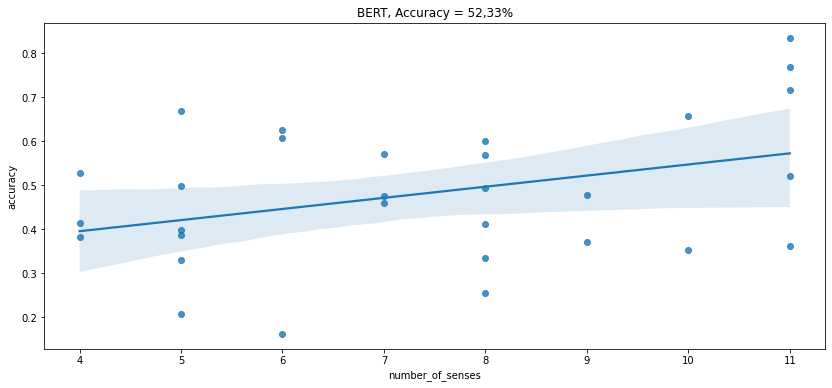

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, (ax1) = plt.subplots(1,1, figsize=(14,6)) 

ax1.set_title('BERT, Accuracy = 52,33%')
sns.regplot(x="number_of_senses", y="accuracy", data=bert_wf_acc, ax=ax1)

<AxesSubplot:title={'center':'LSTM - Approach 2, Accuracy = 49,50%'}, xlabel='number_of_senses', ylabel='accuracy'>

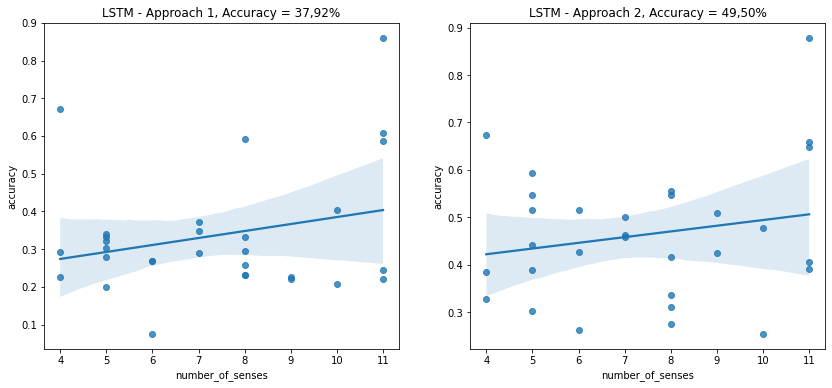

In [50]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,6)) 

ax1.set_title('LSTM - Approach 1, Accuracy = 37,92%')
ax2.set_title('LSTM - Approach 2, Accuracy = 49,50%')
sns.regplot(x="number_of_senses", y="accuracy", data=df_wf_acc, ax=ax1)
sns.regplot(x="number_of_senses", y="accuracy", data=df_wf_acc2, ax=ax2)

It turns out that the accuracy actually increased with the number of word-senses. This is a bit surpising but impressive as it means the model is not confused by different but similar senses.

#### COMPARISON
The plots really help compare the three models, but it is also important to look at the overall accuracy.

+ In this run, BERT's overall accuracy was 52,33%, LSTM 1 - 37,92%, and LSTM 2 - 49,50%. In this particular comparison, BERT seems to be the best, closely followed by the second approach to LSTM, but it is important to remember that these are still really dependent on luck during training (i.e. they architecture is not infallibly great), as in some other runs BERT underperformed significantly. Fiddling around with parameters allowed for improvement.
+ On all of the plots we can see that the line drawn through the results is angled slightly upwards, indicating that in all the models the more senses there are for a word form, the better the model is at predicting them.
+ However, just visually, it seems that for LSTM 2 the points are very spread out, with some with very high accuracy and some with very low. BERT ones are the least spread out (the closest to the line). 
+ It seems like it is the same word forms that perform similarly in different models: "line" has a very high accuracy in all of them, and "national" - very low. Perhaps all of the senses in the former one are very distinct, while it is not the case in the latter. 
+ Compared to the baseline, all the models are better, but naturally there is still room for improvement. 

How does the LSTMs perform in comparison to BERT? What's the difference between representations obtained by the LSTMs and BERT? **[2 marks]**

LSTMs in this assignment perform worse than BERT. However Approach 2 performed very similarily, which surprised us.
The major difference between the two is that for LSTMs we do word embeddings from scratch. This means that we only have a few epochs and limited data to capture the "meaning" of the words in the model. In comparison, BERT already has embeddings for a lot of words, and all we need to do is fine tune, or tweak them to fit our task at hand. This means that essentially the meanings of the words are already there, we just need to train the model to classify word senses based on the context.  
In terms of purely what we use to get predictions (as explained in the answer to an earlier question), in LSTMs we either get a class prediction for a given index, or we base it on the concatenation of the final hidden states for the left-directional and right-directional LSTM. For BERT we get fine-tuned attention-based output for every element of the sentence, which is then pooled and pushed to a classifier layer, which has been trained to use that input to predict one of the 222 classes/word senses. 

What could we do to improve our LSTM word sense disambiguation models and our BERT model? **[4 marks]**

LSTMs:
+ We could experiment more with hyperparameters. When developing working structures of the models, we had really bad results due to low dimensionality etc. of our working parameters.
+ We could combine the two approaches, as suggested in class (use both the index prediction and the final hidden state to predict the word sense).

BERT:
+ We could test using the initial sentence representation (on the first token) and see if that gives better results than pooling the representations for all the elements. Both are claimed to be rather similar in results, but perhaps it would make a difference.
+ Even though we used the suggested hyperparameters perhaps we could also change something there.

Both:
+ We could definitely implement dropout (which we forget to do while developing the models now). This would help counteract potential overfitting.
+ For now the models choose, regardless of the word we are predicting the sense of, a class/sense out of 222 available ones. This means that "keep" can get not only 'keep%2:41:03::' but also 'force%1:18:00::' predicted. Perhaps it would work better if the classifier could only pick from the word senses applicable for the given word. For now just choosing blindly gives us a 1 in 222 chance of being correct. If we narrow it down, we get a, say, 1 in 4 (to 1 in 11) chance, which is a major change. 

# Readings:

[1] Kågebäck, M., & Salomonsson, H. (2016). Word Sense Disambiguation using a Bidirectional LSTM. arXiv preprint arXiv:1606.03568.

[2] https://cl.lingfil.uu.se/~nivre/master/NLP-LexSem.pdf